In [ ]:

# 🛒 Synthetic E-Commerce Data Generator
# Generates realistic data for Customers, Products,
# Orders, OrderItems, and Payments tables
# Compatible with MySQL schema & ML segmentation

!pip install faker pandas numpy tqdm

import pandas as pd
import numpy as np
from faker import Faker
from tqdm import tqdm
from datetime import datetime
import random

# Initialize Faker and set seeds for reproducibility
fake = Faker()
random.seed(42)
np.random.seed(42)


# Configuration

NUM_CUSTOMERS = 500
NUM_PRODUCTS = 200
NUM_ORDERS = 2000
MAX_ITEMS_PER_ORDER = 5

# 1️ Customers Table

genders = ['Male', 'Female', 'Other']
customers = []

for cid in range(1, NUM_CUSTOMERS + 1):
    name = fake.name()
    email = f"user{cid}@example.com"
    age = np.random.randint(18, 70)
    gender = random.choices(genders, weights=[0.45, 0.45, 0.1])[0]
    join_date = fake.date_between(start_date='-3y', end_date='today')
    customers.append([cid, name, email, age, gender, join_date])

customers_df = pd.DataFrame(customers, columns=[
    "CustomerID", "Name", "Email", "Age", "Gender", "JoinDate"
])


# 2️ Products Table

categories = [
    "Electronics", "Clothing", "Beauty", "Home",
    "Books", "Sports", "Toys", "Grocery"
]

products = []
for pid in range(1, NUM_PRODUCTS + 1):
    category = random.choice(categories)
    name = f"{fake.catch_phrase()} {category}"
    price = np.random.randint(100, 20000)       # in rupees
    stock_qty = np.random.randint(10, 500)
    products.append([pid, name, category, price, stock_qty])

products_df = pd.DataFrame(products, columns=[
    "ProductID", "Name", "Category", "Price", "StockQty"
])

# 3️⃣ Orders Table

statuses = ["Pending", "Completed", "Cancelled"]
orders = []

for oid in tqdm(range(1, NUM_ORDERS + 1), desc="Generating Orders"):
    customer_id = np.random.randint(1, NUM_CUSTOMERS + 1)
    join_date = customers_df.loc[
        customers_df.CustomerID == customer_id, "JoinDate"
    ].values[0]

    order_date = fake.date_time_between_dates(
        datetime.strptime(str(join_date), "%Y-%m-%d"), datetime.now()
    )

    status = random.choices(statuses, weights=[0.1, 0.8, 0.1])[0]
    total_amount = np.random.randint(200, 20000)

    orders.append([oid, customer_id, order_date, total_amount, status])

orders_df = pd.DataFrame(orders, columns=[
    "OrderID", "CustomerID", "OrderDate", "TotalAmount", "Status"
])

# 4️⃣ OrderItems Table

order_items = []
order_item_id = 1

for _, order in tqdm(orders_df.iterrows(), total=len(orders_df), desc="Generating Order Items"):
    num_items = np.random.randint(1, MAX_ITEMS_PER_ORDER + 1)
    selected_products = np.random.choice(products_df.ProductID, size=num_items, replace=False)

    for pid in selected_products:
        quantity = np.random.randint(1, 5)
        price = products_df.loc[products_df.ProductID == pid, "Price"].values[0]
        order_items.append([order_item_id, order["OrderID"], pid, quantity, price])
        order_item_id += 1

orderitems_df = pd.DataFrame(order_items, columns=[
    "OrderItemID", "OrderID", "ProductID", "Quantity", "Price"
])

# 5️⃣ Payments Table

payment_methods = ["Card", "UPI", "Cash", "NetBanking"]
payment_statuses = ["Success", "Failed", "Pending"]

payments = []
for order_id in tqdm(orders_df["OrderID"], desc="Generating Payments"):
    method = random.choices(payment_methods, weights=[0.4, 0.3, 0.2, 0.1])[0]
    status = random.choices(payment_statuses, weights=[0.85, 0.1, 0.05])[0]
    payment_date = fake.date_time_between(start_date='-1y', end_date='now')
    amount = orders_df.loc[orders_df.OrderID == order_id, "TotalAmount"].values[0]

    payments.append([order_id, order_id, payment_date, amount, method, status])

payments_df = pd.DataFrame(payments, columns=[
    "PaymentID", "OrderID", "PaymentDate", "Amount", "PaymentMethod", "Status"
])


# 💾 Save to CSV

customers_df.to_csv("/content/customers.csv", index=False)
products_df.to_csv("/content/products.csv", index=False)
orders_df.to_csv("/content/orders.csv", index=False)
orderitems_df.to_csv("/content/orderitems.csv", index=False)
payments_df.to_csv("/content/payments.csv", index=False)

print("✅ CSV files generated successfully in /content/")
print("Files saved:")
print(" - customers.csv")
print(" - products.csv")
print(" - orders.csv")
print(" - orderitems.csv")
print(" - payments.csv")


100%|██████████| 2000/2000 [00:00<00:00, 2346.43it/s]


✅ CSV files generated successfully in /content/
Files: customers.csv, products.csv, orders.csv, orderitems.csv, payments.csv


In [ ]:
from google.colab import files

files_to_download = [
    "customers.csv",
    "products.csv",
    "orders.csv",
    "orderitems.csv",
    "payments.csv"
]

for f in files_to_download:
    files.download(f)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

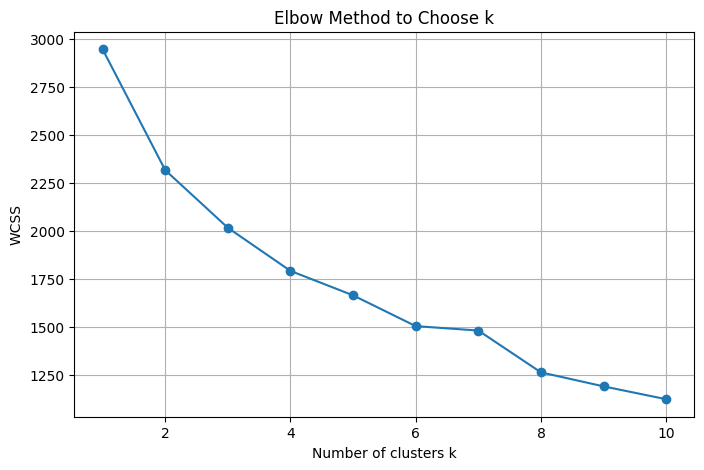

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 1️⃣ Load Data
customers = pd.read_csv("/content/customers.csv")
orders = pd.read_csv("/content/orders.csv")

# 2️⃣ Compute Customer Features
customer_features = orders.groupby("CustomerID").agg(
    total_spent=("TotalAmount", "sum"),
    num_orders=("OrderID", "count"),
    avg_order_value=("TotalAmount", "mean"),
    last_order_date=("OrderDate", "max")
).reset_index()

customer_features['last_order_date'] = pd.to_datetime(customer_features['last_order_date'])
customer_features['recency_days'] = (datetime.now() - customer_features['last_order_date']).dt.days

# Encode gender
customers['Gender'] = customers['Gender'].map({'Male':0,'Female':1,'Other':2})
customer_features = customer_features.merge(customers[['CustomerID','Age','Gender']], on='CustomerID')

# Features for clustering
X = customer_features.drop(columns=['CustomerID','last_order_date']).values  # convert to numpy array

# Optional: Standardize features for better clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3️⃣ Manual WCSS / Elbow
wcss = []  # Within-cluster sum of squares

for k in range(1, 11):
    # Randomly initialize centroids
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for _ in range(10):  # simple K-Means iteration
        # Assign clusters
        clusters = np.array([np.argmin([np.linalg.norm(x - c) for c in centroids]) for x in X])
        # Update centroids
        centroids = np.array([X[clusters == i].mean(axis=0) for i in range(k)])

    # Compute WCSS
    wcss.append(sum(np.linalg.norm(X[i] - centroids[clusters[i]])**2 for i in range(len(X))))

# 4️⃣ Plot Elbow
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('WCSS')
plt.title('Elbow Method to Choose k')
plt.grid(True)
plt.show()


In [ ]:
!pip install kneed

from kneed import KneeLocator

k_values = range(1, 11)
knee = KneeLocator(k_values, wcss, curve='convex', direction='decreasing')
optimal_k = knee.knee
print("Optimal number of clusters k =", optimal_k)


Optimal number of clusters k = 4
